In [2]:
import time
start = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import gc

In [12]:
# Read the data and indexing id column in train and test data so that it will be easy to merge.
train = pd.read_csv("../input/train.csv",index_col="id")
testing = pd.read_csv("../input/test.csv")
test = pd.read_csv("../input/test.csv",index_col="id")
#replacing null values with the string missing data.
resource = pd.read_csv("../input/resources.csv").fillna("missingdata")

In [10]:
#Size of tha dataset.
print("Train data size: ",train.shape)
print("Test data size: ",test.shape)
print("Resource data size: ",resource.shape)

('Train data size: ', (182080, 15))
('Test data size: ', (78035, 14))
('Resource data size: ', (1541272, 4))


In [13]:
# Taking sum of quantity and price of same id in resource and then merging train and test data with resources file.
merge_resource = resource.reset_index().groupby('id').agg(dict(quantity = 'sum', price = 'sum', description = lambda x: ' sumvalue '.join(x)))
train_data = pd.merge(train,merge_resource, left_index=True, right_index=True, how= "inner")
test_data = pd.merge(test,merge_resource, left_index=True, right_index=True, how= "inner")

In [14]:
train_data.head()

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,description,quantity
id,,,,,,,,,,,,,,,,,,
p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,299.98,Apple - iPod nano� 16GB MP3 Player (8th Genera...,6
p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,20.00,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,20
p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,469.99,3doodler Start Full Edu Bundle,1
p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,684.47,BALL PG 4'' POLY SET OF 6 COLORS sumvalue BALL...,5
p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,355.50,Crown Berkey Water Filter With 2 Black and 2 P...,2


In [16]:
#The size of the train and test data set should be same after merging. The merge should happen according to id.
#check size after merging.
print("Train data size after merge: ",train_data.shape)
print("Test data size after merge: ",test_data.shape)

('Train data size after merge: ', (182080, 18))
('Test data size after merge: ', (78035, 17))


In [17]:
#info of train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182080 entries, p036502 to p190772
Data columns (total 18 columns):
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                                 6374 non-null object
project_resource_summary               

In [18]:
#check description of the train data.
train_data.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
count,182080.000000,182080.000000,182080.000000,182080.000000
mean,11.237055,0.847682,297.731304,16.971447
std,28.016086,0.359330,366.718002,26.241957
min,0.000000,0.000000,0.660000,1.000000
25%,0.000000,1.000000,104.480000,4.000000
50%,2.000000,1.000000,205.980000,9.000000
75%,9.000000,1.000000,379.000000,21.000000
max,451.000000,1.000000,9999.000000,930.000000


In [19]:
#check for missing values and displaying count for each feature for train data.
total = train_data.isnull().sum().sort_values(ascending = False)
print(total.count)

<bound method Series.count of project_essay_4                                 175706
project_essay_3                                 175706
teacher_prefix                                       4
quantity                                             0
project_title                                        0
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_essay_1                                      0
description                                          0
project_essay_2                                      0
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
price                                                0
teacher_id                         

In [54]:
# Data visualization and checking important features
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
categories_count= train_data["project_subject_categories"].value_counts()
grph = go.Bar(x = categories_count.index, y = (categories_count / categories_count.sum())*100,)
data = [grph]
layout = go.Layout(
    title = "CatgoricalDistribution",
    xaxis=dict(
        title='Project category',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Percentage of proposals',
        titlefont=dict(
            size=16,
            color='rgb(139, 0, 139)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(139, 0, 139)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [56]:
count_approved = train_data['project_is_approved'].value_counts()
cal_percent= (count_approved / count_approved.sum())*100
labels = count_approved.index
grph1 = go.Pie(labels=labels, values=cal_percent, hoverinfo='label')
data = [grph1]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [59]:
prefix_count = train_data["teacher_prefix"].value_counts()
grph2 = go.Bar(x = prefix_count.index, y = (prefix_count / prefix_count.sum())*100,)
data = [grph2]
layout = go.Layout(
    xaxis=dict(title='Teacher prefix',tickfont=dict(size=14, color='rgb(139, 0, 139)')),
    yaxis=dict(titlefont=dict(size=16,color='rgb(139, 0, 139)'),tickfont=dict(size=14,color='rgb(139, 0, 139)'))
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [60]:
#Combining the features that are important for prediction.
train_data['combined_essay'] = train_data.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_title']),
    str(row['description']),
    str(row['project_resource_summary'])
    ]), axis=1)

test_data['combined_essay'] = test_data.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_title']),
    str(row['description']),
    str(row['project_resource_summary'])
    ]), axis=1)

In [61]:
train_data.combined_essay[0]

'Most of my kindergarten students come from low-income households and are considered \\"at-risk\\". These kids walk to school alongside their parents and most have never been further than walking distance from their house. For 80% of my students, English is not their first language or the language spoken at home. \\r\\n\\r\\nWhile my kindergarten kids have many obstacles in front of them, they come to school each day excited and ready to learn. Most students started the year out never being in a school setting. At the start of the year many had never been exposed to letters. Each day they soak up more knowledge and try their hardest to succeed. They are highly motivated to learn new things every day. We are halfway through the year and they are starting to take off. They know know all letters, some sight words, numbers to 20, and a majority of their letter sounds because of their hard work and determination. I am excited to see the places we will go from here! I currently have a differ

In [62]:
text_training = pd.concat([train_data['combined_essay'], test_data['combined_essay']])

In [63]:
vect = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1, 2),
    max_features = 9000)

vect.fit(text_training)

train_transformer = vect.transform(train_data['combined_essay'])

test_transformer = vect.transform(test_data['combined_essay'])

In [66]:
from sklearn.naive_bayes import MultinomialNB
outcome = train_data['project_is_approved']
nb = MultinomialNB()
nb.fit(train_transformer, outcome)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
test.head()

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
id,,,,,,,,,,,,,,
p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


In [68]:
add_id = pd.DataFrame.from_dict({'id': testing['id']})
add_id['project_is_approved'] = nb.predict_proba(test_transformer)[:, 1]

In [69]:
print(add_id[0:10])

        id  project_is_approved
0  p233245             0.846464
1  p096795             0.835708
2  p236235             0.852190
3  p233680             0.826317
4  p171879             0.838651
5  p016071             0.978955
6  p099906             0.950945
7  p200236             0.899455
8  p129452             0.524962
9  p186652             0.873749


In [98]:
#scores = []
validation_score = cross_val_score(nb, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
nbmean_cv_score = np.mean(validation_score)
print('Mean CV:',nbmean_cv_score)

[ 0.82013895  0.82158941  0.82142465  0.82238576  0.82111767]
('Mean CV:', 0.82133128832779667)


In [71]:
add_id.to_csv('submission_final.csv', index=False)

In [72]:
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(train_transformer, outcome)
output = pd.DataFrame.from_dict({'id': testing['id']})
output['project_is_approved'] = classifier.predict_proba(test_transformer)[:, 1]

In [99]:
#scores = []
validation_score = cross_val_score(classifier, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
lrmean_cv_score = np.mean(validation_score)
print('Mean CV:',lrmean_cv_score)

[ 0.8483126   0.84866542  0.84822605  0.84869288  0.84846904]
('Mean CV:', 0.84847319945318667)


In [74]:
output.to_csv('256submission_lr.csv', index=False)

In [75]:
from numpy import loadtxt
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier()
model.fit(train_transformer, outcome)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
xg_output = pd.DataFrame.from_dict({'id': testing['id']})
xg_output['project_is_approved'] = model.predict_proba(test_transformer)[:, 1]

In [77]:
print(xg_output[0:10])

        id  project_is_approved
0  p233245             0.932342
1  p096795             0.780904
2  p236235             0.925716
3  p233680             0.764940
4  p171879             0.758862
5  p016071             0.892360
6  p099906             0.926808
7  p200236             0.889689
8  p129452             0.663071
9  p186652             0.940648


In [78]:
xg_output.to_csv('256submission_xg.csv', index=False)

In [100]:
#scores = []
validation_score = cross_val_score(model, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
xgmean_cv_score = np.mean(validation_score)
print('Mean CV:',xgmean_cv_score)

[ 0.84809292  0.84819859  0.84797891  0.84830844  0.84808458]
('Mean CV:', 0.84813268888212279)


In [81]:
from sklearn.ensemble import AdaBoostClassifier
ad_clf = AdaBoostClassifier(n_estimators=100)
ad_clf.fit(train_transformer, outcome)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [82]:
ad_output = pd.DataFrame.from_dict({'id': testing['id']})
ad_output['project_is_approved'] = ad_clf.predict_proba(test_transformer)[:, 1]

In [83]:
print(ad_output[0:10])

        id  project_is_approved
0  p233245             0.507326
1  p096795             0.502456
2  p236235             0.507428
3  p233680             0.504663
4  p171879             0.501805
5  p016071             0.505949
6  p099906             0.506123
7  p200236             0.507026
8  p129452             0.501011
9  p186652             0.508732


In [84]:
ad_output.to_csv('256submission_ad.csv', index=False)

In [101]:
#scores = []
validation_score = cross_val_score(ad_clf, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
admean_cv_score = np.mean(validation_score)
print('Mean CV:',admean_cv_score)

[ 0.84776341  0.8471551   0.84814367  0.8483359   0.84753536]
('Mean CV:', 0.84778668591799811)


In [86]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('lr', classifier), ('xg', model), ('ad', ad_clf)], voting='soft')
eclf.fit(train_transformer, outcome)

VotingClassifier(estimators=[('lr', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)), ('xg', XGBClassifier...='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [87]:
eclf_output = pd.DataFrame.from_dict({'id': testing['id']})
eclf_output['project_is_approved'] = eclf.predict_proba(test_transformer)[:, 1]

In [88]:
print(eclf_output[0:10])

        id  project_is_approved
0  p233245             0.790223
1  p096795             0.709623
2  p236235             0.782413
3  p233680             0.697182
4  p171879             0.689697
5  p016071             0.777131
6  p099906             0.781852
7  p200236             0.774190
8  p129452             0.575512
9  p186652             0.791673


In [89]:
eclf_output.to_csv('256submission_eclf.csv', index=False)

In [103]:
#scores = []
validation_score = cross_val_score(eclf, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
ecmean_cv_score = np.mean(validation_score)
print('Mean CV:',ecmean_cv_score)

[ 0.84809292  0.84819859  0.84797891  0.84830844  0.84808458]
('Mean CV:', 0.84813268888212279)


In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

ran_clf = RandomForestClassifier(n_estimators=10)
ran_clf.fit(train_transformer, outcome)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
ran_output = pd.DataFrame.from_dict({'id': testing['id']})
ran_output['project_is_approved'] = ran_clf.predict_proba(test_transformer)[:, 1]

In [93]:
print(ran_output[0:10])

        id  project_is_approved
0  p233245                  0.9
1  p096795                  0.6
2  p236235                  1.0
3  p233680                  0.9
4  p171879                  1.0
5  p016071                  1.0
6  p099906                  1.0
7  p200236                  0.8
8  p129452                  0.5
9  p186652                  0.9


In [94]:
ran_output.to_csv('256submission_ran.csv', index=False)

In [104]:
#scores = []
validation_score = cross_val_score(ran_clf, train_transformer, outcome, cv=5)
#scores.append(validation_score)
print(validation_score)
rfmean_cv_score = np.mean(validation_score)
print('Mean CV:',rfmean_cv_score)

[ 0.83655985  0.83542948  0.83608853  0.83636314  0.83690787]
('Mean CV:', 0.83626977344035147)


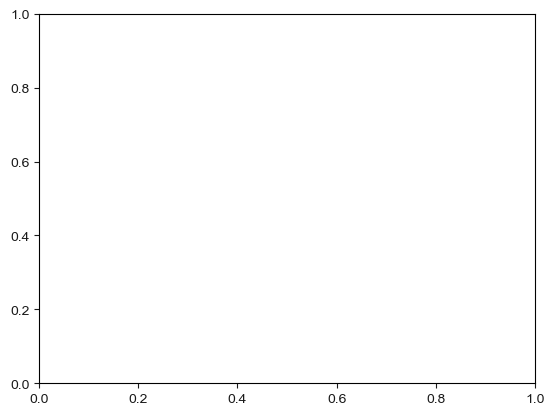

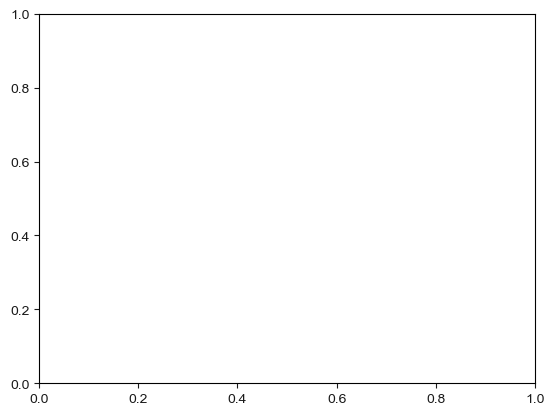

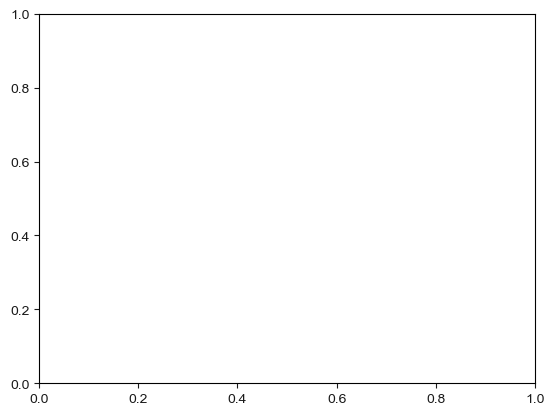

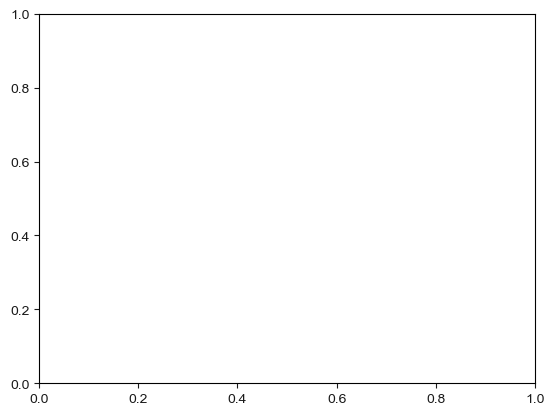

<Figure size 640x480 with 0 Axes>

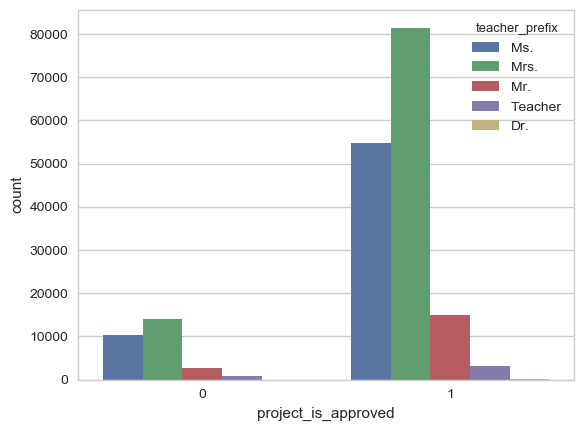

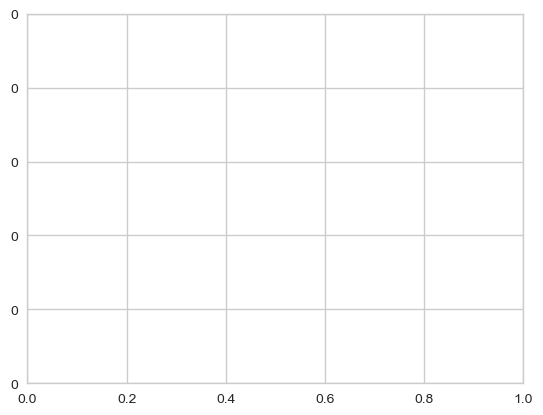

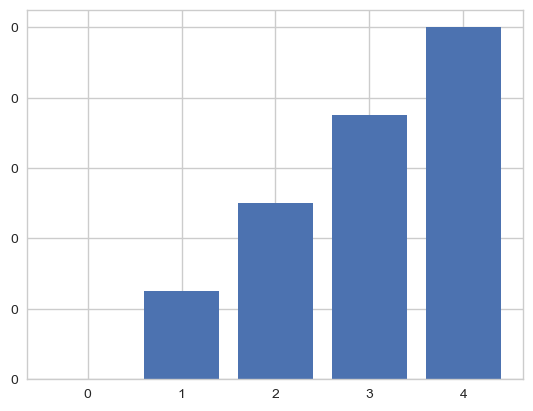

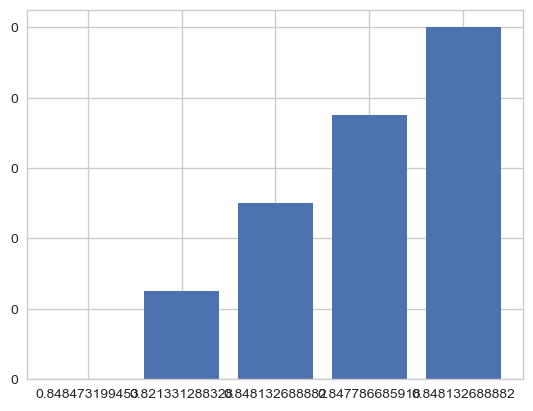

In [107]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(5)
scores = [0, 0.25, 0.5, 0.75, 1.0]


def millions(x, pos):
    
    return '0' % (x * 1e-6)


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, scores)
plt.xticks(x, (lrmean_cv_score, nbmean_cv_score, xgmean_cv_score, admean_cv_score,ecmean_cv_score, rfmean_cv_score ))
plt.show()